In [2]:
import numpy as np
a=np.random.random((32, 224, 224, 3))
b=np.random.random((32, 224, 224, 3))
b=b.mean(axis=0)
print(b.shape)
c=a*b
c=(c-c.mean())/c.std()
out=c.sum(axis=-1).mean(axis=0)
print(out.shape)

(224, 224, 3)
(224, 224)


In [6]:
import pandas as pd

X = [
     [4, 2, 2],
     [4, 1, 1],
     [3, 2, 2],
     [3, 3, 2],
     [1, 3, 1],
     [3, 2, 2],
     [3, 3, 2],
     [4, 2, 2],
]

df=pd.DataFrame(X, columns=["Height", "Width", "Length"])
df.groupby(["Height", "Width"]).count().unstack()

Length          
Width       1    2    3
Height                 
1         NaN  NaN  1.0
3         NaN  2.0  2.0
4         1.0  2.0  NaN

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.utils import lemmatize
import spacy
from nltk.corpus import stopwords as sw
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

plt.rcParams["figure.figsize"] = (20, 10)
sns.set(style="darkgrid", rc={"figure.figsize": (20, 10)})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# 0. Dataset loading

In [ ]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
!unzip DSL2122_january_dataset.zip

--2022-01-18 11:11:25--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640208 (18M) [application/zip]
Saving to: ‘DSL2122_january_dataset.zip’

DSL2122_january_dat 100%[===================>]  17.78M  5.11MB/s    in 3.5s    

2022-01-18 11:11:30 (5.11 MB/s) - ‘DSL2122_january_dataset.zip’ saved [18640208/18640208]

Archive:  DSL2122_january_dataset.zip
   creating: DSL2122_january_dataset/
  inflating: DSL2122_january_dataset/development.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._development.csv  
  inflating: DSL2122_january_dataset/sample_submission.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._sample_submission.csv  
  inflating: DSL2122_january_dataset/evaluation.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._evalua

In [ ]:
df = pd.read_csv("DSL2122_january_dataset/development.csv")
df

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
224989,0,2261324310,Sat Jun 20 20:36:48 PDT 2009,NO_QUERY,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,Mon Jun 01 01:25:45 PDT 2009,NO_QUERY,unitechy,Trying the qwerty keypad
224991,0,1991221316,Mon Jun 01 06:38:10 PDT 2009,NO_QUERY,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,Fri Jun 19 08:51:56 PDT 2009,NO_QUERY,Ginger_Billie,I am really tired and bored and bleh! I feel c...


In [ ]:
df_eval = pd.read_csv("DSL2122_january_dataset/evaluation.csv")
df_eval

,ids,date,flag,user,text
0,1999928613,Mon Jun 01 21:04:54 PDT 2009,NO_QUERY,urbanperspectiv,@engteacher I'm pretty much the same ...in eit...
1,1827919331,Sun May 17 11:43:09 PDT 2009,NO_QUERY,therealsecret,@JaxLicurse same here have a gr8 week ahead
2,1563640134,Sun Apr 19 23:37:52 PDT 2009,NO_QUERY,bitchville,@blacksweater that's just nightmares all over
3,2189786396,Tue Jun 16 00:54:27 PDT 2009,NO_QUERY,epi_longo,@dlead @jishanvn cháº¯c pháº£i Äi thi Äáº¡i ...
4,1974034022,Sat May 30 12:18:33 PDT 2009,NO_QUERY,Curiosafmmb,@CA_Sweetie awe. ok sweetie. ttyl. *hugs*
...,...,...,...,...,...
74994,1933009490,Tue May 26 22:45:42 PDT 2009,NO_QUERY,Irv25,"@NIYANA man down,code 10...I'm going 2 try &am..."
74995,1563759085,Mon Apr 20 00:08:25 PDT 2009,NO_QUERY,iHomeTech,@senhordaguerra Thank you for following me: I ...
74996,1754026098,Sun May 10 04:38:13 PDT 2009,NO_QUERY,danger_skies,Why isn't Friday's Hollyoaks available for dow...
74997,2288725776,Mon Jun 22 19:32:13 PDT 2009,NO_QUERY,tracyewilli,@hollywilli she WAS !!! she was a MADAM they q...


In [ ]:
# Why here I get the correct characters? What is the correct encoding?
# I suppose there has been some conversions that generated errors
# Original tweet: https://twitter.com/epi_longo/status/2189786396
with open("DSL2122_january_dataset/evaluation.csv", "rb") as f:
  q = f.read()
  print(q[450:500].decode("utf8").encode("latin_1")[:30].decode("utf8"))

chắc phải đi thi đại h


# 1. Data inspection

In [ ]:
df.describe()

,sentiment,ids
count,224994.000000,2.249940e+05
mean,0.578491,1.988334e+09
std,0.493802,1.777980e+08
min,0.000000,1.467811e+09
25%,0.000000,1.956965e+09
50%,1.000000,1.996993e+09
75%,1.000000,2.064995e+09
max,1.000000,2.329205e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


## 1.1 sentiment

In [ ]:
df["sentiment"].value_counts()

1    130157
0     94837
Name: sentiment, dtype: int64

In [ ]:
# In percentages
df["sentiment"].value_counts(normalize=True)

1    0.578491
0    0.421509
Name: sentiment, dtype: float64

There is a slight unbalance in the sentiment classes

|Value|Count|Percentages|
|-----|-----|-----------|
|1 (Positive)|130157|57.85%|
|0 (Negative)|94837|42.15%|

## 1.2 ids

In [ ]:
ids_count = df["ids"].value_counts()
ids_count

2059315682    2
1793985425    2
1693267481    2
1976810843    2
1880946156    2
             ..
1961241909    1
2204063297    1
1685366335    1
2221328380    1
2265974785    1
Name: ids, Length: 224716, dtype: int64

In [ ]:
df.drop_duplicates(subset=["ids", "user", "date", "text", "sentiment"])

,sentiment,ids,date,user,text
0,1,1833972543,2009-05-18 01:08:27,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,2009-05-31 06:23:17,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,2009-06-01 11:52:54,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,2009-05-17 02:45:34,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,2009-06-02 00:08:07,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...
224989,0,2261324310,2009-06-20 20:36:48,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,2009-06-01 01:25:45,unitechy,Trying the qwerty keypad
224991,0,1991221316,2009-06-01 06:38:10,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,2009-06-19 08:51:56,Ginger_Billie,I am really tired and bored and bleh! I feel c...


In [ ]:
df[df["ids"].isin(ids_count.index[ids_count.values==1])].sort_values("ids")

,sentiment,ids,date,user,text
126514,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
23977,0,1467811594,2009-04-06 22:20:03,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
198394,0,1467813579,2009-04-06 22:20:31,starkissed,@LettyA ahh ive always wanted to see rent lov...
188913,0,1467813782,2009-04-06 22:20:34,gi_gi_bee,@FakerPattyPattz Oh dear. Were you drinking ou...
212404,0,1467819650,2009-04-06 22:22:05,antzpantz,@Viennah Yay! I'm happy for you with your job!...
...,...,...,...,...,...
94121,0,2329167439,2009-06-25 10:25:48,Tracey_Mac,Already dreading being car-less tomorrow!!! b...
71783,0,2329176482,2009-06-25 10:26:26,kinaton,wishes he could win a holiday for his familty
40052,0,2329197868,2009-06-25 10:27:58,Arantza92,@LisaHopeCyrus yes he was such a jerk and so m...
90305,0,2329199154,2009-06-25 10:28:03,shen_nanigans,@rlangeles no. I slept Ina lil.. But it still...


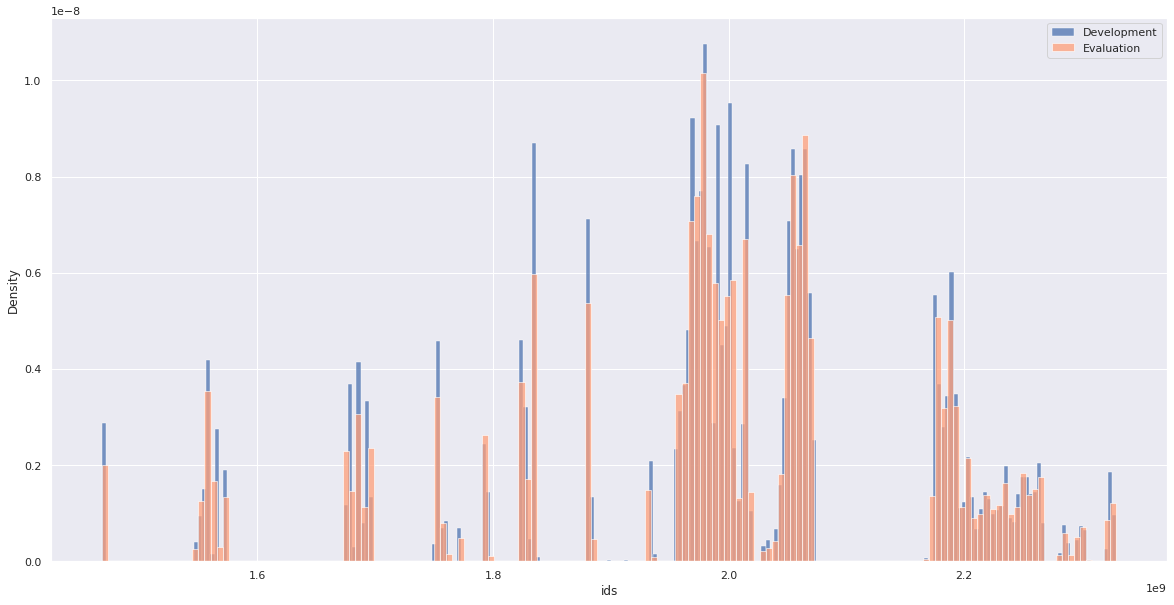

In [ ]:
sns.histplot(df, x="ids", label="Development", stat="density")
sns.histplot(df_eval, x="ids", color="lightsalmon", label="Evaluation", stat="density")
plt.legend()

The ids are separated in intervals and they have similar densities in the development and evaluation, probably they are correlated with dates.

## 1.3 date

### 1.3.1 Convert to datetime
date column is of type object, so it needs to be converted to datetime type

In [ ]:
pd.to_datetime(df["date"])

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


0        2009-05-18 01:08:27
1        2009-05-31 06:23:17
2        2009-06-01 11:52:54
3        2009-05-17 02:45:34
4        2009-06-02 00:08:07
                 ...        
224989   2009-06-20 20:36:48
224990   2009-06-01 01:25:45
224991   2009-06-01 06:38:10
224992   2009-06-19 08:51:56
224993   2009-06-03 06:00:29
Name: date, Length: 224994, dtype: datetime64[ns]

In [ ]:
# We get a warning about the timezone which is not taken into consideration
# Are all dates in PDT time zone? YES, as you can see from the prints
print(all(["PDT" in d for d in df["date"] ]))
print(all(["PDT" in d for d in df_eval["date"] ]))

True
True


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df_eval["date"] = pd.to_datetime(df_eval["date"])
df["date"]

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


0        2009-05-18 01:08:27
1        2009-05-31 06:23:17
2        2009-06-01 11:52:54
3        2009-05-17 02:45:34
4        2009-06-02 00:08:07
                 ...        
224989   2009-06-20 20:36:48
224990   2009-06-01 01:25:45
224991   2009-06-01 06:38:10
224992   2009-06-19 08:51:56
224993   2009-06-03 06:00:29
Name: date, Length: 224994, dtype: datetime64[ns]

### 1.3.2 Correlation with ids
Let's test the hypothesis that ids are correlated with dates

In [ ]:
df["ids"].corr(pd.Series([ d.timestamp() for d in df["date"]]))

0.9942496504055086

Indeed they are highly correlated. So probably is **not** a good idea to **include both**.

## 1.4 flag

In [ ]:
df["flag"]

0         NO_QUERY
1         NO_QUERY
2         NO_QUERY
3         NO_QUERY
4         NO_QUERY
            ...   
224989    NO_QUERY
224990    NO_QUERY
224991    NO_QUERY
224992    NO_QUERY
224993    NO_QUERY
Name: flag, Length: 224994, dtype: object

Are all values equal to NO_QUERY?

In [ ]:
all(df["flag"] == "NO_QUERY")

True

In [ ]:
all(df_eval["flag"] == "NO_QUERY")

True

Yes, so the flag column is useless and can be dropped

In [ ]:
df.drop(columns="flag", inplace=True)
df_eval.drop(columns="flag", inplace=True)

## 1.5 user

In [ ]:
df["user"].unique()

array(['Killandra', 'IMlisacowan', 'yaseminx3', ..., 'samozzy',
       'hEATHER_nVA', 'Rokkster'], dtype=object)

In [ ]:
df["user"].value_counts()

lost_dog           412
webwoke            259
tweetpet           232
SallytheShizzle    211
VioletsCRUK        209
                  ... 
janellepinky        11
JujuDeRoussie       11
EverywhereTrip      11
kasmac92            11
lilbabygirlloz      11
Name: user, Length: 10647, dtype: int64

In [ ]:
df_eval["user"].value_counts()

lost_dog           137
webwoke             86
tweetpet            78
SallytheShizzle     70
VioletsCRUK         70
                  ... 
redcomet81           4
__xEW                4
hoppets              4
bumposaurus          4
CherylAddict_GM      4
Name: user, Length: 10647, dtype: int64

In both datasets there are 10647 unique users, but are they the same?

In [ ]:
all(df_eval["user"].isin(df["user"]))

True

Yes, they have the same users.

## 1.6 text

### 1.6.1 Distribution of text length

In [ ]:
min([ len(text) for text in df["text"]])

6

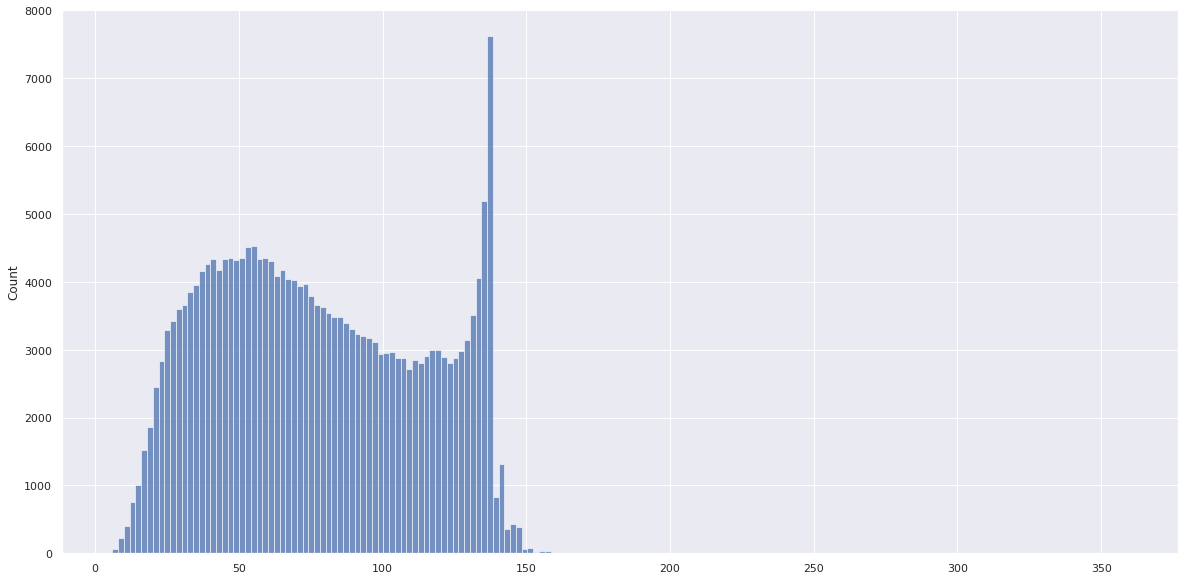

In [ ]:
sns.histplot([ len(text) for text in df["text"]])

Let's explore the outliers.

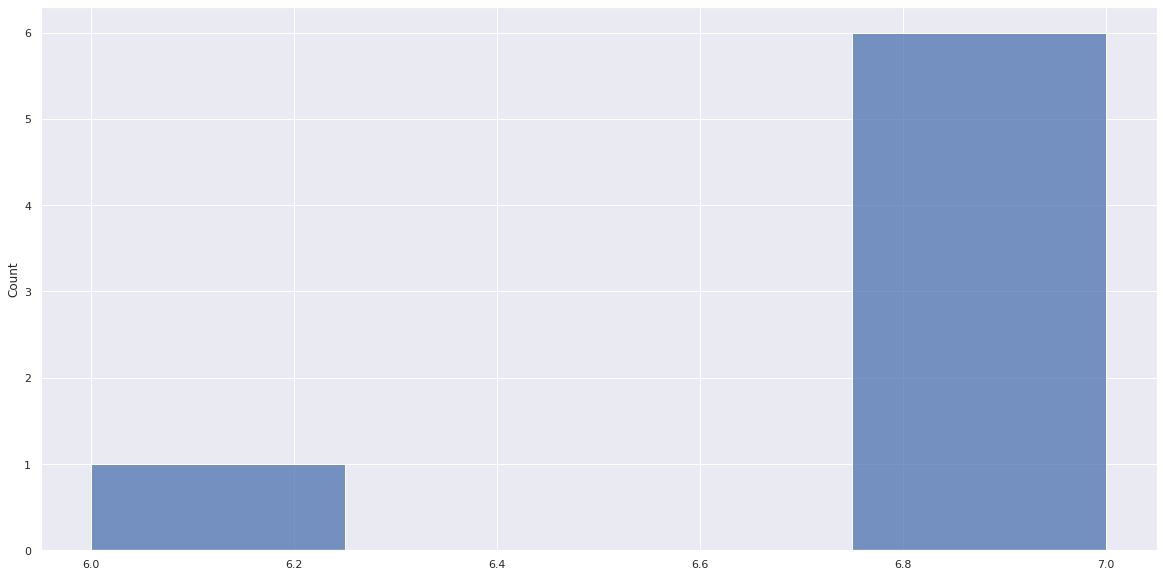

In [ ]:
sns.histplot([ len(text) for text in df["text"] if len(text) < 8])

In [ ]:
# Shortest text
lengths = np.array([ len(text) for text in df["text"]])
df["text"][lengths == min(lengths)].values[0]

'Ugh   '

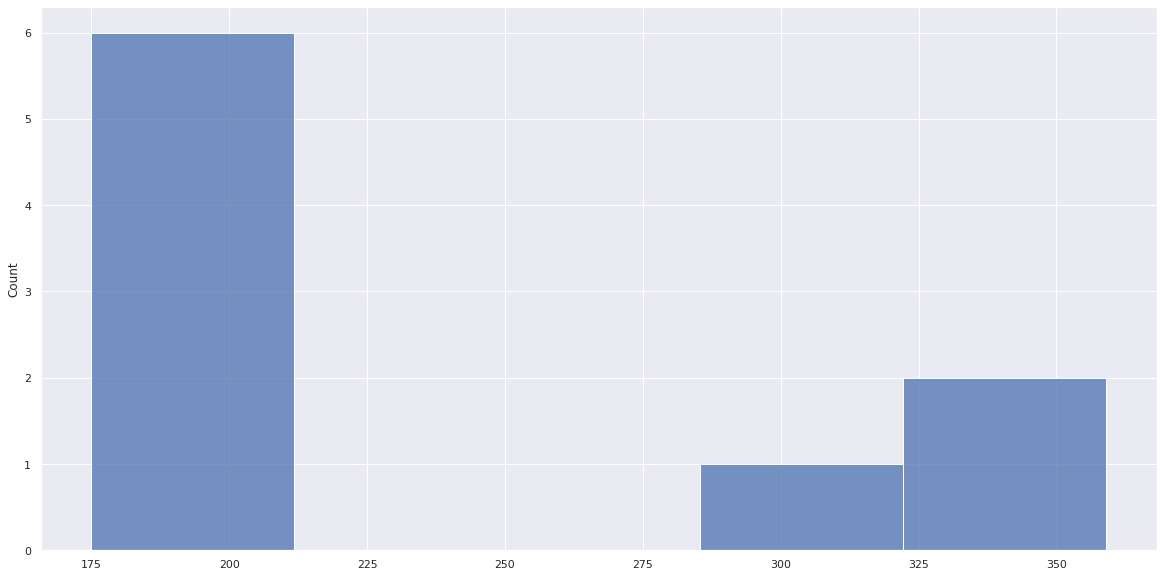

In [ ]:
sns.histplot([ len(text) for text in df["text"] if len(text) > 170])

In [ ]:
# Longest text
lengths = np.array([ len(text) for text in df["text"]])
df["text"][lengths == max(lengths)].values[0]

'5 days till new top gear  î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95î?\x95'

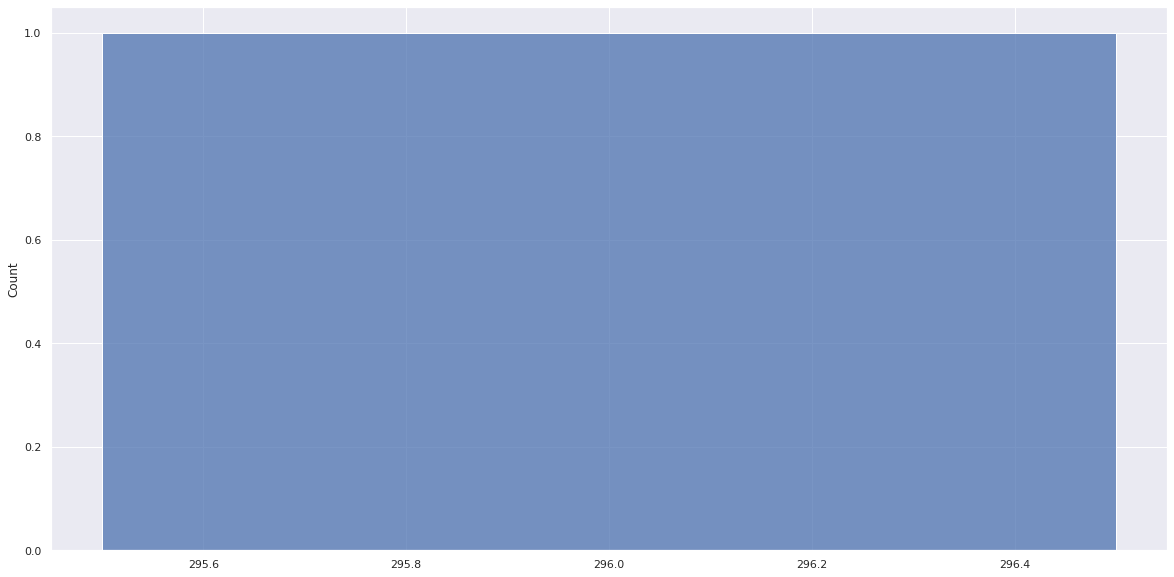

In [ ]:
sns.histplot([ len(text) for text in df_eval["text"] if len(text) > 280])

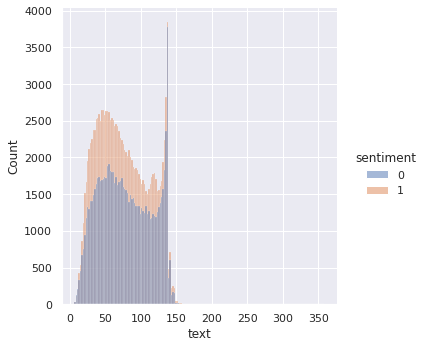

In [ ]:
sns.displot(pd.DataFrame([ [len(text), sent] for text, sent in zip(df["text"], df["sentiment"])], columns=["text", "sentiment"]), x="text", hue="sentiment")

# 2. Preprocessing

## 2.1 Text

### 2.1.1 Convert HTML characters in text

In [ ]:
df["text"] = df["text"].apply(lambda x: BeautifulSoup(x).get_text())
df_eval["text"] = df_eval["text"].apply(lambda x: BeautifulSoup(x).get_text())

### 2.1.2 Text lemmatization

In [ ]:
sentence = "They've been playing all around, I'd like to stop it, someone doesn't and I can't @user #hash :)!"

In [ ]:
class LemmaTokenizer(object):
  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()
  def __call__(self, document):
    lemmas = []
    for t in word_tokenize(document):
      t = t.strip()
      lemma = self.lemmatizer.lemmatize(t)
      lemmas.append(lemma)
    return lemmas
lemmaTokenizer = LemmaTokenizer()
lemmaTokenizer(sentence)

['They',
 "'ve",
 'been',
 'playing',
 'all',
 'around',
 ',',
 'I',
 "'d",
 'like',
 'to',
 'stop',
 'it',
 ',',
 'someone',
 'doe',
 "n't",
 'and',
 'I',
 'ca',
 "n't",
 '@',
 'user',
 '#',
 'hash',
 ':',
 ')',
 '!']

In [ ]:
!pip install pattern
from pattern.en import lemma

     |████████████████████████████████| 22.2 MB 1.4 MB/s 
     |████████████████████████████████| 87 kB 5.5 MB/s 
     |████████████████████████████████| 81 kB 8.0 MB/s 
     |████████████████████████████████| 5.6 MB 36.8 MB/s 
     |████████████████████████████████| 5.6 MB 35.3 MB/s 
     |████████████████████████████████| 419 kB 59.9 MB/s 
     |████████████████████████████████| 104 kB 60.1 MB/s 
     |████████████████████████████████| 3.6 MB 38.9 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=eedc57ed42aa87a9cbfad6b7bc6a54c1f65f45e323e09dfc45be4fcb4ec818ad
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99981 sha256=9dfb2e47fb3e5d1a1c08de6a6302f9f099ecb4f9937fe0c3d35efd31686d0e66
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
  

In [ ]:
class LemmaTokenizerPattern(object):
  def __call__(self, document):
    lemmas = []
    for t in word_tokenize(document):
      t = t.strip()
      l = lemma(t)
      lemmas.append(l)
    return lemmas
lemmaTokenizerPattern = LemmaTokenizerPattern()
lemmaTokenizerPattern(sentence)

['they',
 'have',
 'be',
 'play',
 'all',
 'around',
 ',',
 'i',
 'will',
 'like',
 'to',
 'stop',
 'it',
 ',',
 'someone',
 'do',
 'be',
 'and',
 'i',
 'ca',
 'be',
 '@',
 'user',
 '#',
 'hash',
 ':',
 ')',
 '!']

In [ ]:
from pattern.en import tokenize
class LemmaTokenizerAllPattern(object):
  def __call__(self, document):
    lemmas = []
    for sentence in tokenize(document):
      for split in sentence.split():
        for t in word_tokenize(split):
          t = t.strip()
          l = lemma(t)
          lemmas.append(l)
    return lemmas
lemmaTokenizerAllPattern = LemmaTokenizerAllPattern()
lemmaTokenizerAllPattern(sentence)

['they',
 'have',
 'be',
 'play',
 'all',
 'around',
 ',',
 'i',
 'will',
 'like',
 'to',
 'stop',
 'it',
 ',',
 'someone',
 'do',
 'be',
 'and',
 'i',
 'ca',
 'be',
 '@',
 'user',
 '#',
 'hash',
 ':',
 ')',
 '!']

In [ ]:
from pattern.en import tokenize
replacements = {
     "'d": " 'd",
     "'m": " 'm",
     "'s": " 's",
    "'ll": " 'll",
    "'re": " 're",
    "'ve": " 've",
    "n't": " not",
    "@": "@ "
}
tokenize(sentence, replace=replacements)

["They 've been playing all around , I 'd like to stop it , someone does not and I ca not @ user # hash :) !"]

In [ ]:
class TwitterLemmaTokenizer(object):
  def __init__(self):
    self.tokenizer = TweetTokenizer()
    self.lemmatizer = WordNetLemmatizer()
  def __call__(self, document):
    lemmas = []
    for t in self.tokenizer.tokenize(document):
      t = t.strip()
      lemma = self.lemmatizer.lemmatize(t)
      lemmas.append(lemma)
    return lemmas
twitterLemmaTokenizer = TwitterLemmaTokenizer()
twitterLemmaTokenizer(sentence)

["They've",
 'been',
 'playing',
 'all',
 'around',
 ',',
 "I'd",
 'like',
 'to',
 'stop',
 'it',
 ',',
 'someone',
 "doesn't",
 'and',
 'I',
 "can't",
 ':)',
 '!']

In [ ]:
# class LemmaTokenizerGensim(object):
#   def __call__(self, document):
#     lemmas = []
#     for lemma in lemmatize(sentence):
#       lemmas.append(lemma.decode('utf-8').split('/')[0])
#     return lemmas
# lemmaTokenizerGensim = LemmaTokenizerGensim()
# lemmaTokenizerGensim(sentence)

In [ ]:
class LemmaTokenizerSpacy(object):
  def __init__(self):
    self.nlp = spacy.load('en')
  def __call__(self, document):
    lemmas = []
    for t in self.nlp(document):
      lemmas.append(t.lemma_)
    return lemmas

lemmaTokenizerSpacy = LemmaTokenizerSpacy()
lemmaTokenizerSpacy(sentence)

['-PRON-',
 'have',
 'be',
 'play',
 'all',
 'around',
 ',',
 '-PRON-',
 'would',
 'like',
 'to',
 'stop',
 '-PRON-',
 ':)',
 '!']

In [ ]:
# Since Spacy seems the most promising and it takes lots of time, let's tokenize the text in order to do it only once
nlp = spacy.load('en', disable=["parser", "ner"])
df["text_lemma_tokens"] = [[t.lemma_ for t in nlp(text)] for text in df["text"]]

In [ ]:
df.to_csv("development_tokenized.csv")

In [ ]:
df = pd.read_csv("development_tokenized.csv", index_col=0)
df

,sentiment,ids,date,user,text,text_lemma_tokens
0,1,1833972543,2009-05-18 01:08:27,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...","['@MissBianca76', 'yes', ',', 'talk', 'help', ..."
1,1,1980318193,2009-05-31 06:23:17,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,"['SUNSHINE', '.', 'livingg', 'itttt', '.', 'im..."
2,1,1994409198,2009-06-01 11:52:54,yaseminx3,@PleaseBeMine Something for your iphone,"['@pleasebemine', 'something', 'for', '-PRON-'..."
3,0,1824749377,2009-05-17 02:45:34,no_surprises,@GabrielSaporta couldn't get in to the after p...,"['@GabrielSaporta', 'could', 'not', 'get', 'in..."
4,0,2001199113,2009-06-02 00:08:07,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,"['@bradiewebbstack', 'awww', 'be', 'andy', 'be..."
...,...,...,...,...,...,...
224989,0,2261324310,2009-06-20 20:36:48,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...,"['@dropsofreign', 'yeah', '-PRON-', 'hope', 'I..."
224990,1,1989408152,2009-06-01 01:25:45,unitechy,Trying the qwerty keypad,"['try', 'the', 'qwerty', 'keypad']"
224991,0,1991221316,2009-06-01 06:38:10,Xaan,I love Jasper & Jackson but that wig in the Bd...,"['-PRON-', 'love', 'Jasper', '&', 'Jackson', '..."
224992,0,2239702807,2009-06-19 08:51:56,Ginger_Billie,I am really tired and bored and bleh! I feel c...,"['-PRON-', 'be', 'really', 'tired', 'and', 'bo..."


### 2.1.2 Most frequent words

In [ ]:
# Without lemmatizer and stop words
vectorizer = TfidfVectorizer(use_idf=False, binary=True, norm=False)
wpm = vectorizer.fit_transform(df["text"])
freq_all = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]),key=lambda x: x[1], reverse=True)
len(freq_all)

156707

In [ ]:
# With default stop words, without lemmatizer
vectorizer = TfidfVectorizer(use_idf=False, binary=True, norm=False, stop_words='english')
wpm = vectorizer.fit_transform(df["text"])
freq_stop_def = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]),key=lambda x: x[1], reverse=True)
len(freq_stop_def)

156404

In [ ]:
# With default stop words, with TweetTokenizer
vectorizer = TfidfVectorizer(use_idf=False, binary=True, norm=False, stop_words='english', tokenizer=TweetTokenizer().tokenize)
wpm = vectorizer.fit_transform(df["text"])
freq_stop_def_tweet_tok = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]),key=lambda x: x[1], reverse=True)
len(freq_stop_def_tweet_tok)

167659

In [ ]:
# With nltk stop words and nltk lemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
vectorizer = TfidfVectorizer(use_idf=False, binary=True, norm=False, stop_words=sw.words('english'), tokenizer=lemmaTokenizer)
wpm = vectorizer.fit_transform(df["text"])
freq_stop_nltk = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]),key=lambda x: x[1], reverse=True)
len(freq_stop_nltk)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


173775

In [ ]:
# Without stop words and with spacy lemmatizer
vectorizer = CountVectorizer(binary=True,  stop_words="english", tokenizer=dummy, preprocessor=dummy, max_features=1000)#, max_features=5000)
wpm = vectorizer.fit_transform(df["text_lemma_tokens"])
freq_spacy_count = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]),key=lambda x: x[1], reverse=True)
len(freq_spacy_count)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)


1000

In [ ]:
dict(freq_spacy_count)

{'-PRON-': 166169,
 'be': 109415,
 ' ': 83111,
 '.': 73702,
 '!': 73058,
 'to': 62958,
 'the': 57391,
 ',': 55764,
 'a': 46968,
 'not': 44978,
 'have': 38106,
 'and': 35795,
 'do': 33334,
 '?': 29501,
 'i': 29298,
 'that': 28308,
 'for': 26844,
 'in': 25621,
 '...': 24006,
 'get': 23193,
 'of': 23168,
 'on': 22800,
 'go': 22614,
 'so': 20614,
 'but': 19192,
 'just': 17160,
 'good': 15871,
 'will': 15408,
 'can': 14842,
 '-': 14648,
 'now': 13172,
 'with': 13162,
 'like': 12997,
 '..': 12790,
 'all': 12119,
 'at': 12077,
 'up': 11616,
 'this': 11500,
 'day': 10972,
 'thank': 10906,
 'too': 10863,
 'no': 10516,
 'love': 10362,
 'know': 10020,
 'out': 10011,
 'lol': 9923,
 'what': 9741,
 'think': 9535,
 'well': 9507,
 'see': 9347,
 'one': 8418,
 'u': 8322,
 'time': 8252,
 'work': 8106,
 'how': 7835,
 'make': 7829,
 'there': 7372,
 'if': 7345,
 'want': 7265,
 'about': 7217,
 'oh': 7175,
 'from': 7160,
 'today': 7091,
 'really': 7049,
 'back': 6820,
 'would': 6733,
 '&': 6694,
 '#': 6535,
 

In [ ]:
freq_spacy_dict = dict(freq_spacy)
freq_spacy_dict

{'-PRON-': 151302.0,
 'be': 109870.0,
 'i': 86465.0,
 ' ': 83111.0,
 '.': 73546.0,
 '!': 73058.0,
 'to': 62995.0,
 'the': 57414.0,
 ',': 55764.0,
 'a': 47038.0,
 'not': 45308.0,
 'have': 38134.0,
 'and': 35789.0,
 'do': 33570.0,
 '?': 29501.0,
 'that': 28323.0,
 'for': 26845.0,
 'in': 25625.0,
 '...': 24006.0,
 'get': 23759.0,
 'of': 23167.0,
 'on': 22850.0,
 'go': 22765.0,
 'so': 20686.0,
 'but': 19174.0,
 'just': 17152.0,
 'good': 16382.0,
 'will': 16234.0,
 'can': 15477.0,
 '-': 14644.0,
 'lol': 13615.0,
 'now': 13168.0,
 'with': 13162.0,
 'like': 13003.0,
 '..': 12790.0,
 'all': 12175.0,
 'at': 12094.0,
 'up': 11650.0,
 'this': 11508.0,
 'day': 11369.0,
 'thank': 10994.0,
 'too': 10869.0,
 'love': 10720.0,
 'no': 10525.0,
 'know': 10054.0,
 'out': 10032.0,
 'what': 9746.0,
 'think': 9541.0,
 'well': 9501.0,
 'see': 9384.0,
 'u': 8559.0,
 'one': 8428.0,
 'time': 8422.0,
 'work': 8148.0,
 'make': 7887.0,
 'how': 7839.0,
 'there': 7370.0,
 'if': 7343.0,
 'want': 7271.0,
 'about': 7220

### 2.1.3 Bag of words

**Experiments**

|tokenizer|max_features|stop_words|Score|
|---------|------------|----------|-----|
|spacy|1000|None|0.7518411081814799|
|spacy|All|None|0.768482849914443|
|spacy|1000|"english"|0.7052522903907085 |
|spacy|1000|nltk|0.7130330461139512|
|None|1000|None|0.7493291031713207|
|nltk|1000|None|0.7539143842632884|
|nltk|2000|None|0.7591945167412284|
|nltk|1000|nltk|0.731538636928945|
|Tweet|1000|None|0.7499880690585371|

In [ ]:
def dummy(tokens):
  return tokens

In [ ]:
def bag_of_words(text, stop_words=None, tokenizer=None, preprocessor=None, max_features=None):
  vectorizer = CountVectorizer(binary=True, stop_words=stop_words, tokenizer=tokenizer, preprocessor=preprocessor, max_features=max_features)
  return vectorizer.fit_transform(text)

In [ ]:
def cross_evaluation(model, X):
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  scores = cross_val_score(model, X, df["sentiment"], cv=cv, scoring="f1_macro")
  print(f"Avg: {scores.mean()} Scores: {scores}")

In [ ]:
# spacy ("text_lemma_tokens"), 1000 features
bow = bag_of_words(df["text_lemma_tokens"], tokenizer=dummy, preprocessor=dummy, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7518411081814799 Scores: [0.75563962 0.75103848 0.75253284 0.7521732  0.74782141]


In [ ]:
# spacy ("text_lemma_tokens"), all features
bow = bag_of_words(df["text_lemma_tokens"], tokenizer=dummy, preprocessor=dummy)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.768482849914443 Scores: [0.77254524 0.76766569 0.76523762]


In [ ]:
# spacy ("text_lemma_tokens"), 1000 features, stop words default "english"
bow = bag_of_words(df["text_lemma_tokens"], stop_words="english", tokenizer=dummy, preprocessor=dummy, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)


Avg: 0.7052522903907085 Scores: [0.70509412 0.70544347 0.70521928]


In [ ]:
# spacy ("text_lemma_tokens"), 1000 features, nltk stop words
bow = bag_of_words(df["text_lemma_tokens"], stop_words=sw.words('english'), tokenizer=dummy, preprocessor=dummy, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


Avg: 0.7130330461139512 Scores: [0.71284129 0.71421861 0.71203923]


In [ ]:
# no tokenizer, 1000 features, no stop words
bow = bag_of_words(df["text"], max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7493291031713207 Scores: [0.75167697 0.74988826 0.74642208]


In [ ]:
# twitter+nltk tokenizer, 1000 features, no stop words
bow = bag_of_words(df["text"], tokenizer=twitterLemmaTokenizer, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7508574840191574 Scores: [0.75245566 0.75252571 0.74759108]


In [ ]:
# nltk tokenizer, 1000 features, no stop words
bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7539143842632884 Scores: [0.75567071 0.7544803  0.75159214]


In [ ]:
# nltk tokenizer, 2000 features, no stop words
bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer, max_features=2000)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7591945167412284 Scores: [0.76069333 0.75943182 0.7574584 ]


In [ ]:
# nltk tokenizer, 1000 features, nltk stop words
bow = bag_of_words(df["text"], stop_words=sw.words('english'), tokenizer=lemmaTokenizer, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


Avg: 0.731538636928945 Scores: [0.73119984 0.73196622 0.73144985]


In [ ]:
# Twitter tokenizer, 1000 features, no stop words
bow = bag_of_words(df["text"], tokenizer=TweetTokenizer().tokenize, max_features=1000)
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7499880690585371 Scores: [0.75195877 0.75147571 0.74652972]


#### 2.1.3.1 N-grams

In [ ]:
def bag_of_words(text, stop_words=None, tokenizer=None, preprocessor=None, max_features=None, ngrams=(1, 1)):
  vectorizer = CountVectorizer(binary=True, stop_words=stop_words, tokenizer=tokenizer, preprocessor=preprocessor, max_features=max_features, ngram_range=ngrams)
  return vectorizer.fit_transform(text)

In [ ]:
# nltk tokenizer, 1000 features, no stop words, bigrams
bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer, max_features=1000, ngrams=(1, 2))
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7491045736296066 Scores: [0.75126698 0.74990776 0.74613898]


In [ ]:
# nltk tokenizer, 2000 features, no stop words, trigrams
bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer, max_features=2000, ngrams=(1, 3))
cross_evaluation(RandomForestClassifier(), bow)

Avg: 0.7562813163047641 Scores: [0.75871545 0.75626855 0.75385995]


### 2.1.3.2 Try different models

In [ ]:
bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer, max_features=1000)

In [ ]:
cross_evaluation(RidgeClassifier(), bag_of_words(df["text"], tokenizer=lemmaTokenizer))

Avg: 0.768140062453129 Scores: [0.76748599 0.76962863 0.76730557]


In [ ]:
cross_evaluation(RidgeClassifier(), bow)

Avg: 0.7535750865408154 Scores: [0.75385967 0.754376   0.75248959]


In [ ]:
from sklearn.linear_model import LogisticRegression
cross_evaluation(LogisticRegression(), bow)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Avg: 0.7583238476025348 Scores: [0.75941096 0.75878289 0.75677769]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.svm import LinearSVC
cross_evaluation(LinearSVC(), bow)

Avg: 0.7567399158402043 Scores: [0.75759455 0.75716401 0.75546119]


In [ ]:
from sklearn.svm import SVC
cross_evaluation(SVC(), bow)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
cross_evaluation(MultinomialNB(), bow)

Avg: 0.7475549980396826 Scores: [0.74827182 0.74835579 0.74603738]


In [ ]:
from sklearn.naive_bayes import BernoulliNB
cross_evaluation(BernoulliNB(), bow)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
cross_evaluation(KNeighborsClassifier(), bow)

Avg: 0.6706948968222805 Scores: [0.67158793 0.67154856 0.6689482 ]


### 2.1.4 TF-IDF

In [ ]:
def tfidf(text, stop_words=None, tokenizer=None, preprocessor=None, max_features=None, ngrams=(1, 1)):
  vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenizer, preprocessor=preprocessor, max_features=max_features, ngram_range=ngrams)
  return vectorizer.fit_transform(text)

In [ ]:
# no tokenizer, 1000 features, no stop words
X = tfidf(df["text"], max_features=1000)
cross_evaluation(RandomForestClassifier(), X)

Avg: 0.7516181184969165 Scores: [0.75359283 0.75306188 0.74819965]


In [ ]:
# no tokenizer, 1000 features, no stop words
X = tfidf(df["text"], max_features=1000, tokenizer=lemmaTokenizer)
cross_evaluation(RandomForestClassifier(), X)

Avg: 0.7517347892154058 Scores: [0.75385603 0.75169994 0.7496484 ]


In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
wpm = vectorizer.fit_transform(df["text"])
freq = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]),key=lambda x: x[1], reverse=True)
dict(freq)

{'the': 10352.588076433898,
 'to': 10323.777436609487,
 'you': 9898.415218815418,
 'it': 8480.325779706909,
 'my': 7179.521115498045,
 'and': 6937.225769151486,
 'is': 6114.729428994707,
 'that': 5943.499497473515,
 'for': 5784.624603406011,
 'me': 5465.820745255157,
 'in': 5456.608799139622,
 'on': 4962.380426474235,
 'of': 4948.556765813776,
 'have': 4930.247738853464,
 'so': 4714.04535761319,
 'good': 4167.908036358977,
 'but': 4015.395009954264,
 'just': 4002.7413901850427,
 'lol': 3850.5733899507804,
 'not': 3789.2726668443834,
 'be': 3652.890658721329,
 'was': 3579.4921852488687,
 'are': 3468.1685443160763,
 'now': 3361.4052598310477,
 'with': 3318.7817215512346,
 'can': 3273.3221081064967,
 'like': 3182.0830166595597,
 'too': 3116.4934960902006,
 'thanks': 3079.6020143192686,
 'no': 3065.413343149645,
 'at': 3044.5816522659597,
 'all': 3007.0825794949424,
 'up': 3002.2878818576464,
 'get': 2970.495619883447,
 'your': 2930.6163142001797,
 'love': 2883.6098427943093,
 'this': 2872

### 2.1.4.1 N-grams

In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 2))
cross_evaluation(RidgeClassifier(), X)

Avg: 0.7995594055974528 Scores: [0.80048927 0.80046483 0.79772411]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 3))
cross_evaluation(RidgeClassifier(), X)

Avg: 0.799565164902068 Scores: [0.80128089 0.79982673 0.79758788]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 5))
cross_evaluation(RidgeClassifier(), X)

Avg: 0.7939903864060547 Scores: [0.79633379 0.79362111 0.79201626]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 2))
cross_evaluation(LinearSVC(), X)

Avg: 0.8004037329952117 Scores: [0.80092463 0.80186252 0.79842405]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 3))
cross_evaluation(LinearSVC(), X)

Avg: 0.8023464175587028 Scores: [0.80437277 0.80291578 0.7997507 ]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 4))
cross_evaluation(LinearSVC(), X)

Avg: 0.8005186437966444 Scores: [0.80364759 0.80017757 0.79773078]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 5))
cross_evaluation(LinearSVC(), X)

Avg: 0.7983689064052181 Scores: [0.80143594 0.79757634 0.79609444]


#### 2.1.4.2 Try other models

In [ ]:
X = tfidf(df["text"], max_features=1000, tokenizer=lemmaTokenizer)
cross_evaluation(RidgeClassifier(), X)

Avg: 0.7565536549621324 Scores: [0.75688628 0.75652785 0.75624684]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer)
cross_evaluation(RidgeClassifier(), X)

Avg: 0.7827575487374383 Scores: [0.78356613 0.78371124 0.78099528]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer)
cross_evaluation(LinearSVC(), X)

Avg: 0.7815134370844418 Scores: [0.7830194  0.78142041 0.78010051]


In [ ]:
X = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 3))

In [ ]:
from sklearn.linear_model import LogisticRegression
cross_evaluation(LogisticRegression(max_iter=1000), X)

Avg: 0.7858405002515413 Scores: [0.78724197 0.78563466 0.78464486]


In [ ]:
from sklearn.svm import SVC
cross_evaluation(SVC(), X)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
cross_evaluation(MultinomialNB(), X)

Avg: 0.725832392400433 Scores: [0.72606109 0.72592178 0.72551431]


In [ ]:
from sklearn.naive_bayes import BernoulliNB
cross_evaluation(BernoulliNB(), X)

Avg: 0.6626560470566348 Scores: [0.66122741 0.66401417 0.66272656]


### 2.1.5 BoW + TF-IDF

In [ ]:
X_bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer, max_features=1000)
X_tfidf = tfidf(df["text"], tokenizer=lemmaTokenizer, max_features=1000)
X = hstack((X_bow, X_tfidf))
cross_evaluation(RandomForestClassifier(), X)

Avg: 0.7527853345823939 Scores: [0.75400298 0.7532791  0.75107392]


### 2.1.5.1 Try different models

In [ ]:
X_bow = bag_of_words(df["text"], tokenizer=lemmaTokenizer)
X_tfidf = tfidf(df["text"], tokenizer=lemmaTokenizer)
X = hstack((X_bow, X_tfidf))

In [ ]:
cross_evaluation(RidgeClassifier(), X)

Avg: 0.768110745563405 Scores: [0.76748063 0.76989486 0.76695675]


In [ ]:
cross_evaluation(LinearSVC(), X)

Avg: 0.7671895335249298 Scores: [0.76734698 0.76875355 0.76546807]


In [ ]:
from sklearn.linear_model import LogisticRegression
cross_evaluation(LogisticRegression(), X)

In [ ]:
from sklearn.svm import SVC
cross_evaluation(SVC(), X)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
cross_evaluation(MultinomialNB(), X)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
cross_evaluation(BernoulliNB(), X)

#### Wordclouds

In [ ]:
from wordcloud import WordCloud

In [ ]:
def frequencies(text, vectorizer):
  matrix = vectorizer.fit_transform(text)
  feature_names = vectorizer.get_feature_names_out()
  lst = matrix.todense().tolist()
  df = pd.DataFrame(lst, columns=feature_names)
  return df.transpose().sum(axis=1)

In [ ]:
frequencies(df["text"], CountVectorizer(binary=True, tokenizer=lemmaTokenizer, max_features=500))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


!            73544
#             6580
&            14747
'             3404
'd            2205
             ...  
yes           3811
yesterday     1053
yet           1924
you          45182
your         10488
Length: 500, dtype: int64

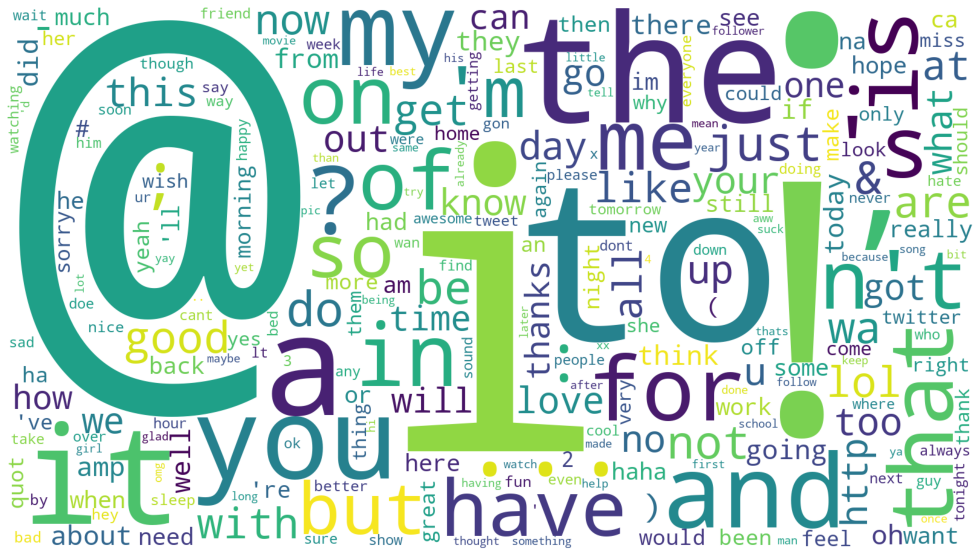

In [ ]:
# bow_frequencies = frequencies(df["text"], CountVectorizer(binary=True, tokenizer=lemmaTokenizer, max_features=500))
wordcloud = WordCloud(background_color="white", width=1600, height=900, max_words=250, min_font_size=10).generate_from_frequencies(bow_frequencies)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("bow_wordcloud.svg", format="svg")

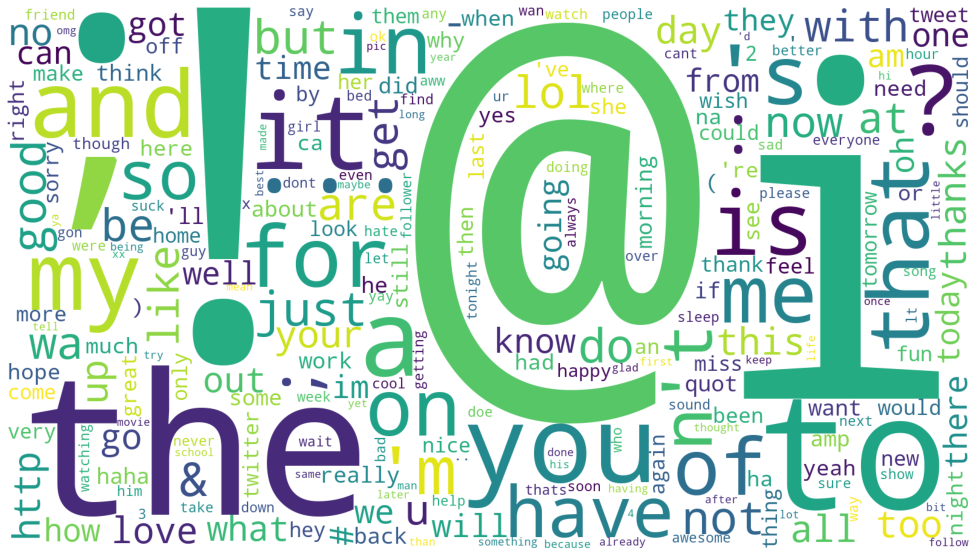

In [ ]:
# tfidf_frequencies = frequencies(df["text"], TfidfVectorizer(tokenizer=lemmaTokenizer, max_features=250))
wordcloud = WordCloud(background_color="white", width=1600, height=900, max_words=250, min_font_size=10).generate_from_frequencies(tfidf_frequencies)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("tfidf_wordcloud.svg", format="svg")

### 2.1.6 Word2Vec

In [ ]:
from gensim.models import Word2Vec

tokenized_tweet = df["text"].apply(lambda x: lemmaTokenizer(x)) # tokenizing 

model_w2v = Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            #window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            #hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 42
) 

model_w2v.train(tokenized_tweet, total_examples= len(df["text"]), epochs=20)

(54812269, 77337100)

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(224994, 200)

In [ ]:
cross_evaluation(RandomForestClassifier(), wordvec_df)

Avg: 0.7303848550517458 Scores: [0.72959106 0.73178397 0.72977954]


In [ ]:
import xgboost as xgb
cross_evaluation(xgb.XGBClassifier(), wordvec_df)

Avg: 0.7330148140991976 Scores: [0.73139398 0.73335381 0.73429665]


In [ ]:
cross_evaluation(RidgeClassifier(), wordvec_df)

Avg: 0.7546314579059005 Scores: [0.75586964 0.75623684 0.7517879 ]


In [ ]:
cross_evaluation(LinearSVC(), wordvec_df)

Avg: 0.7590516522973202 Scores: [0.7602791  0.76066958 0.75620628]


### 2.1.7 Doc2Vec

In [ ]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from tqdm import tqdm 

In [ ]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


In [ ]:
labeled_tweets = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_tweet)]

In [ ]:
model_d2v = Doc2Vec(labeled_tweets, vector_size = 20, window = 2, min_count = 1, epochs = 100)

In [ ]:
model_d2v = Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 42, # for reproducibility
                                 ) 

model_d2v.build_vocab([label for label in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(df["text"]), epochs=20)

100%|██████████| 224994/224994 [00:00<00:00, 2748439.62it/s]


In [ ]:
docvec_arrays = np.zeros((len(tokenized_tweet), 20)) 
for i in range(len(labeled_tweets)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,20))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(224994, 20)

In [ ]:
cross_evaluation(RandomForestClassifier(), docvec_df)

Avg: 0.6429781560006432 Scores: [0.642848   0.64161109 0.64447538]


In [ ]:
cross_evaluation(RidgeClassifier(), docvec_df)

Avg: 0.6589977148013927 Scores: [0.65891587 0.65700172 0.66107555]


In [ ]:
cross_evaluation(LinearSVC(), docvec_df)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Avg: 0.6593030312766702 Scores: [0.65912768 0.65724979 0.66153162]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### 2.1.8 FastText

In [ ]:
from gensim.models import FastText

model_fast = FastText(seed=42)
#             tokenized_tweet,
#             size=200, # desired no. of features/independent variables
#             #window=5, # context window size
#             min_count=2, # Ignores all words with total frequency lower than 2.                                  
#             sg = 1, # 1 for skip-gram model
#             #hs = 0,
#             negative = 10, # for negative sampling
#             workers= 32, # no.of cores
#             seed = 42
# ) 
model_fast.build_vocab(tokenized_tweet)
model_fast.train(tokenized_tweet, total_examples= len(df["text"]), epochs=20)

In [ ]:
def word_vector(tokens, size, model):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
def encode_words(model, size):
  wordfast_arrays = np.zeros((len(tokenized_tweet), size)) 
  for i in range(len(tokenized_tweet)):
      wordfast_arrays[i,:] = word_vector(tokenized_tweet[i], size, model)
  return pd.DataFrame(wordfast_arrays)

In [ ]:
cross_evaluation(RandomForestClassifier(), encode_words(model_fast, 100))

Avg: 0.6939840840572143 Scores: [0.69438495 0.69420798 0.69335932]


In [ ]:
model_fast_200 = FastText(size=200, seed=42, sg=1)
model_fast_200.build_vocab(tokenized_tweet)
model_fast_200.train(tokenized_tweet, total_examples= len(df["text"]), epochs=20)

In [ ]:
cross_evaluation(RandomForestClassifier(), encode_words(model_fast_200, 200))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Avg: 0.7312861429276967 Scores: [0.73059909 0.73061859 0.73264075]


In [ ]:
fasttext_df = encode_words(model_fast_200, 200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### 2.1.10 Word2Vec + Doc2Vec + FastText

In [ ]:
X = pd.concat((wordvec_df, docvec_df, fasttext_df), axis=1)

In [ ]:
cross_evaluation(RandomForestClassifier(), X)

Avg: 0.7359184233999203 Scores: [0.73645316 0.73622251 0.7350796 ]


## 2.2 Ids

In [ ]:
X_tfidf = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 3))
X = hstack((X_tfidf, df["ids"].values.reshape((-1, 1))))

In [ ]:
cross_evaluation(LinearSVC(), X)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Avg: 0.3431617821924591 Scores: [0.29652003 0.36648534 0.36647998]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
cross_evaluation(RidgeClassifier(), X)

In [ ]:
cross_evaluation(RandomForestClassifier(), X)

## 2.3 User

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
X_users = ohe.fit_transform(df["user"].values.reshape(-1, 1))

In [ ]:
X_tfidf = tfidf(df["text"], tokenizer=lemmaTokenizer, ngrams=(1, 3))
X_us = hstack((X_tfidf, X_users))

In [ ]:
cross_evaluation(LinearSVC(), X_us)

Avg: 0.8299281495474707 Scores: [0.83151607 0.83087592 0.82739246]


In [ ]:
cross_evaluation(RidgeClassifier(), X_us)

Avg: 0.8282813275350999 Scores: [0.82918086 0.82961334 0.82604978]


In [ ]:
cross_evaluation(RandomForestClassifier(), X_us)

# Model selection

## TF-IDF with ngrams + user

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def column_selector(cols):
  return ColumnTransformer([("columntransformer", "passthrough", cols)], remainder="drop")

def user_reshape(user):
  return user.reshape(-1, 1)

In [ ]:
def tfidf_user_pipeline(model):
  col_selector = column_selector(["text", "user"])
  user_encoding = make_pipeline(FunctionTransformer(user_reshape), OneHotEncoder(handle_unknown="ignore"))
  col_transformer = make_column_transformer((TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), (user_encoding, 1))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
# Only tfidf
cross_evaluation(tfidf_user_pipeline(LinearSVC()), df["text"])

Avg: 0.8056765230131614 Scores: [0.80722326 0.80656913 0.80323718]


In [ ]:
cross_evaluation(tfidf_user_pipeline(LinearSVC()), df)

Avg: 0.8338851681836088 Scores: [0.83465089 0.83548338 0.83152124]


In [ ]:
cross_evaluation(tfidf_user_pipeline(RidgeClassifier()), df)

Avg: 0.8340575063578329 Scores: [0.83476816 0.83586745 0.83153691]


## TF-IDF + ids

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import FunctionTransformer

In [ ]:
def tfidf_ids_pipeline(model):
  col_selector = column_selector(["text", "ids"])
  ids_scaling = make_pipeline(FunctionTransformer(user_reshape), MinMaxScaler())
  col_transformer = make_column_transformer((TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), (ids_scaling, 1))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_ids_pipeline(LinearSVC()), df)

Avg: 0.8135420192204462 Scores: [0.81549333 0.81469029 0.81044243]


In [ ]:
cross_evaluation(tfidf_ids_pipeline(RidgeClassifier()), df)

Avg: 0.8132455035698349 Scores: [0.81509704 0.81452888 0.8101106 ]


In [ ]:
def tfidf_ids_standard_pipeline(model):
  col_selector = column_selector(["text", "ids"])
  ids_scaling = make_pipeline(FunctionTransformer(user_reshape), StandardScaler())
  col_transformer = make_column_transformer((TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), (ids_scaling, 1))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_ids_standard_pipeline(LinearSVC()), df)

Avg: 0.8135383252553198 Scores: [0.81549333 0.81467743 0.81044421]


In [ ]:
cross_evaluation(tfidf_ids_standard_pipeline(RidgeClassifier()), df)

Avg: 0.813238234864742 Scores: [0.81510813 0.81449417 0.81011241]


### TF-IDF+date (timestamp)

In [ ]:
df["timestamp"] = df["date"].apply(lambda date: date.timestamp())

In [ ]:
def tfidf_timestamp_pipeline(model):
  col_selector = column_selector(["text", "timestamp"])
  timestamp_scaling = make_pipeline(FunctionTransformer(user_reshape), MinMaxScaler())
  col_transformer = make_column_transformer((TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), (timestamp_scaling, 1))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_timestamp_pipeline(LinearSVC()), df)

Avg: 0.8115352841360922 Scores: [0.8134778  0.81253838 0.80858968]


## TF-IDF+user+ids

In [ ]:
def tfidf_user_ids_pipeline(model):
  col_selector = column_selector(["text", "user", "ids"])
  user_encoding = make_pipeline(FunctionTransformer(user_reshape), OneHotEncoder(handle_unknown="ignore"))
  ids_scaling = make_pipeline(FunctionTransformer(user_reshape), MinMaxScaler())
  col_transformer = make_column_transformer((TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), (user_encoding, 1), (ids_scaling, 2))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_user_ids_pipeline(LinearSVC()), df)

Avg: 0.8387895219173153 Scores: [0.83945242 0.84097772 0.83593842]


In [ ]:
cross_evaluation(tfidf_user_ids_pipeline(RidgeClassifier()), df)

Avg: 0.839068329203101 Scores: [0.84027592 0.84108465 0.83584442]


In [ ]:
from sklearn.neural_network import MLPClassifier
cross_evaluation(tfidf_user_ids_pipeline(MLPClassifier(random_state=42)), df)

### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(RidgeClassifier(), random_state=42)
cross_evaluation(tfidf_user_ids_pipeline(clf), df)

Avg: 0.8337710934659482 Scores: [0.83481884 0.83550433 0.83099011]


In [ ]:
clf = BaggingClassifier(LinearSVC(), n_estimators=20, bootstrap_features=True, random_state=42, verbose=3)
cross_evaluation(tfidf_user_ids_pipeline(clf), df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s finished


Avg: 0.835875848431516 Scores: [0.83784697 0.83713841 0.83264216]


### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
estimators = [("LinearSVC", LinearSVC()), ("RidgeClassifier", RidgeClassifier())]
cross_evaluation(tfidf_user_ids_pipeline(StackingClassifier(estimators)), df)
# Avg: 0.8397969422965463 Scores: [0.84049484 0.84211572 0.83678026]

### HashingVectorizer

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
def hashing_user_ids_pipeline(model):
  col_selector = column_selector(["text", "user", "ids"])
  user_encoding = make_pipeline(FunctionTransformer(user_reshape), OneHotEncoder(handle_unknown="ignore"))
  ids_scaling = make_pipeline(FunctionTransformer(user_reshape), MinMaxScaler())
  col_transformer = make_column_transformer((HashingVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), (user_encoding, 1), (ids_scaling, 2))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(hashing_user_ids_pipeline(RidgeClassifier()), df)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Avg: 0.8340008722830726 Scores: [0.83537646 0.83523107 0.83139508]


In [ ]:
cross_evaluation(hashing_user_ids_pipeline(LinearSVC()), df)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Avg: 0.833417668879124 Scores: [0.83355639 0.8356169  0.83107972]


## TruncatedSVD

In [ ]:
def tfidf_pipeline(model):
  col_selector = column_selector(["text"])
  col_transformer = make_column_transformer((TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_pipeline(LinearSVC()), df)

Avg: 0.8056765230131614 Scores: [0.80722326 0.80656913 0.80323718]


In [ ]:
cross_evaluation(tfidf_pipeline(RidgeClassifier()), df)

Avg: 0.8048035198369052 Scores: [0.80642117 0.80520337 0.80278602]


In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
def tfidf_truncated_pipeline(model):
  col_selector = column_selector(["text"])
  truncated = make_pipeline(TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), TruncatedSVD(n_components=100))
  col_transformer = make_column_transformer((truncated, 0))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_truncated_pipeline(LinearSVC()), df)

Avg: 0.7048955130351146 Scores: [0.70230261 0.70722619 0.70515775]


## Add field with text length and number of !

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
def text_stats(posts):
  return [{"length": len(text), "num_esclamations": text.count("!")} for text in posts]

In [ ]:
def tfidf_add_field_pipeline(model):
  col_selector = column_selector(["text"])
  col_transformer = make_column_transformer(
      (TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0),
      (make_pipeline(FunctionTransformer(text_stats), DictVectorizer(sparse=False), MinMaxScaler()), 0))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_add_field_pipeline(LinearSVC()), df)

Avg: 0.8047925474523739 Scores: [0.80658767 0.80590046 0.8018895 ]


In [ ]:
cross_evaluation(tfidf_add_field_pipeline(RidgeClassifier()), df)

Avg: 0.8038330332416826 Scores: [0.80560464 0.80474294 0.80115153]


In [ ]:
def text_stats(posts):
  return [{"length": len(text)} for text in posts]

In [ ]:
cross_evaluation(tfidf_add_field_pipeline(LinearSVC()), df)

Avg: 0.8049291115098113 Scores: [0.80677225 0.80602153 0.80199355]


In [ ]:
cross_evaluation(tfidf_add_field_pipeline(RidgeClassifier()), df)

Avg: 0.8038940104029212 Scores: [0.80565884 0.80476161 0.80126158]


### Field number of positive and negative emojis

In [ ]:
def load_dict_smileys():
    
    return { "smiley": [
        ":‑)",
        ":-]",
        ":-3",
        ":->",
        "8-)",
        ":-}",
        ":)",
        ":]",
        ":3",
        ":>",
        "8)",
        ":}",
        ":o)",
        ":c)",
        ":^)",
        "=]",
        "=)",
        ":-))",
        ":‑D",
        "8‑D",
        "x‑D",
        "X‑D",
        ":D",
        "8D",
        "xD",
        "XD"],
        "sad": [
        ":‑(",
        ":‑c",
        ":‑<",
        ":‑[",
        ":(",
        ":c",
        ":<",
        ":[",
        ":-||",
        ">:[",
        ":{",
        ":@",
        ">:(",
        ":'‑(",
        ":'("],
        "playful": [
        ":‑P",
        "X‑P",
        "x‑p",
        ":‑p",
        ":‑Þ",
        ":‑þ",
        ":‑b",
        ":P",
        "XP",
        "xp",
        ":p",
        ":Þ",
        ":þ",
        ":b"],
        "love": ["<3"]
        }

In [ ]:
def text_stats(posts):
  return [ {key: sum([text.count(emoji) for emoji in value]) for key, value in load_dict_smileys().items()} for text in posts]

In [ ]:
cross_evaluation(tfidf_add_field_pipeline(LinearSVC()), df)

Avg: 0.8056905313329453 Scores: [0.80721039 0.80660026 0.80326094]


In [ ]:
cross_evaluation(tfidf_add_field_pipeline(RidgeClassifier()), df)

Avg: 0.8047761751949758 Scores: [0.80639701 0.80525612 0.8026754 ]


In [ ]:
EMOTICONS_EMO = {
    u":‑)":"Happy face or smiley",
    u":-))":"Very Happy face or smiley",
    u":-)))":"Very very Happy face or smiley",
    u":)":"Happy face or smiley",
    u":))":"Very Happy face or smiley",
    u":)))":"Very very Happy face or smiley",
    u":-]":"Happy face or smiley",
    u":]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-)":"Happy face smiley",
    u":o)":"Happy face smiley",
    u":-}":"Happy face smiley",
    u":}":"Happy face smiley",
    u":-)":"Happy face smiley",
    u":c)":"Happy face smiley",
    u":^)":"Happy face smiley",
    u"=]":"Happy face smiley",
    u"=)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B^D":"Laughing, big grin or laugh with glasses",
    u":-))":"Very happy",
    u":-(":"Frown, sad, andry or pouting",
    u":‑(":"Frown, sad, andry or pouting",
    u":(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑[":"Frown, sad, andry or pouting",
    u":[":"Frown, sad, andry or pouting",
    u":-||":"Frown, sad, andry or pouting",
    u">:[":"Frown, sad, andry or pouting",
    u":{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:(":"Frown, sad, andry or pouting",
    u":'‑(":"Crying",
    u":'(":"Crying",
    u":'‑)":"Tears of happiness",
    u":')":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-*":"Kiss",
    u":*":"Kiss",
    u":X":"Kiss",
    u";‑)":"Wink or smirk",
    u";)":"Wink or smirk",
    u"*-)":"Wink or smirk",
    u"*)":"Wink or smirk",
    u";‑]":"Wink or smirk",
    u";]":"Wink or smirk",
    u";^)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑|":"Straight face",
    u":|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑)":"Angel, saint or innocent",
    u"O:)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑)":"Angel, saint or innocent",
    u"0:)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;^)":"Angel, saint or innocent",
    u">:‑)":"Evil or devilish",
    u">:)":"Evil or devilish",
    u"}:‑)":"Evil or devilish",
    u"}:)":"Evil or devilish",
    u"3:‑)":"Evil or devilish",
    u"3:)":"Evil or devilish",
    u">;)":"Evil or devilish",
    u"|;‑)":"Cool",
    u"|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑)":"Party all night",
    u"%‑)":"Drunk or confused",
    u"%)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑|":"Dump",
    u"(>_<)":"Troubled",
    u"(>_<)>":"Troubled",
    u"(';')":"Baby",
    u"(^^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"(^_^;)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"(-_-;)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"(~_~;) (・.・;)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"(-_-)zzz":"Sleeping",
    u"(^_-)":"Wink",
    u"((+_+))":"Confused",
    u"(+o+)":"Confused",
    u"(o|o)":"Ultraman",
    u"^_^":"Joyful",
    u"(^_^)/":"Joyful",
    u"(^O^)／":"Joyful",
    u"(^o^)／":"Joyful",
    u"(__)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_(._.)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<(_ _)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m(__)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(__)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(_ _)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"('_')":"Sad or Crying",
    u"(/_;)":"Sad or Crying",
    u"(T_T) (;_;)":"Sad or Crying",
    u"(;_;":"Sad of Crying",
    u"(;_:)":"Sad or Crying",
    u"(;O;)":"Sad or Crying",
    u"(:_;)":"Sad or Crying",
    u"(ToT)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q.Q":"Sad or Crying",
    u"T.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"(-.-)":"Shame",
    u"(-_-)":"Shame",
    u"(一一)":"Shame",
    u"(；一_一)":"Shame",
    u"(=_=)":"Tired",
    u"(=^·^=)":"cat",
    u"(=^··^=)":"cat",
    u"=_^= ":"cat",
    u"(..)":"Looking down",
    u"(._.)":"Looking down",
    u"^m^":"Giggling with hand covering mouth",
    u"(・・?":"Confusion",
    u"(?_?)":"Confusion",
    u">^_^<":"Normal Laugh",
    u"<^!^>":"Normal Laugh",
    u"^/^":"Normal Laugh",
    u"（*^_^*）" :"Normal Laugh",
    u"(^<^) (^.^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^.^)":"Normal Laugh",
    u"(^_^.)":"Normal Laugh",
    u"(^_^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^J^)":"Normal Laugh",
    u"(*^.^*)":"Normal Laugh",
    u"(^—^）":"Normal Laugh",
    u"(#^.^#)":"Normal Laugh",
    u"（^—^）":"Waving",
    u"(;_;)/~~~":"Waving",
    u"(^.^)/~~~":"Waving",
    u"(-_-)/~~~ ($··)/~~~":"Waving",
    u"(T_T)/~~~":"Waving",
    u"(ToT)/~~~":"Waving",
    u"(*^0^*)":"Excited",
    u"(*_*)":"Amazed",
    u"(*_*;":"Amazed",
    u"(+_+) (@_@)":"Amazed",
    u"(*^^)v":"Laughing,Cheerful",
    u"(^_^)v":"Laughing,Cheerful",
    u"((d[-_-]b))":"Headphones,Listening to music",
    u'(-"-)':"Worried",
    u"(ーー;)":"Worried",
    u"(^0_0^)":"Eyeglasses",
    u"(＾ｖ＾)":"Happy",
    u"(＾ｕ＾)":"Happy",
    u"(^)o(^)":"Happy",
    u"(^O^)":"Happy",
    u"(^o^)":"Happy",
    u")^o^(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o.O":"Surpised",
    u"(o.o)":"Surprised",
    u"oO":"Surprised",
    u"(*￣m￣)":"Dissatisfied",
    u"(‘A`)":"Snubbed or Deflated"
}

In [ ]:
def emoticons_stats(posts):
  return {key: sum([text.count(key) for text in posts]) for key, value in EMOTICONS_EMO.items()}

In [ ]:
emo_stats = emoticons_stats(df["text"])
emo_stats

{'#‑)': 0,
 '%)': 4,
 '%‑)': 0,
 '(#^.^#)': 0,
 "(';')": 0,
 "('_')": 0,
 '((+_+))': 0,
 '((d[-_-]b))': 0,
 '(*^.^*)': 0,
 '(*^0^*)': 0,
 '(*^^)v': 0,
 '(*_*)': 0,
 '(*_*;': 0,
 '(*￣m￣)': 0,
 '(+_+) (@_@)': 0,
 '(+o+)': 0,
 '(-"-)': 0,
 '(-.-)': 0,
 '(-_-)': 1,
 '(-_-)/~~~ ($··)/~~~': 0,
 '(-_-)zzz': 0,
 '(-_-;)': 0,
 '(..)': 0,
 '(._.)': 0,
 '(/_;)': 0,
 '(:_;)': 0,
 '(;O;)': 0,
 '(;_:)': 0,
 '(;_;': 0,
 '(;_;)/~~~': 0,
 '(=^·^=)': 0,
 '(=^··^=)': 0,
 '(=_=)': 0,
 '(>_<)': 0,
 '(>_<)>': 0,
 '(?_?)': 0,
 '(T_T) (;_;)': 0,
 '(T_T)/~~~': 0,
 '(ToT)': 0,
 '(ToT)/~~~': 0,
 '(^)o(^)': 0,
 '(^.^)': 0,
 '(^.^)/~~~': 0,
 '(^0_0^)': 0,
 '(^<^) (^.^)': 0,
 '(^J^)': 0,
 '(^O^)': 0,
 '(^O^)／': 0,
 '(^^)': 0,
 '(^^>``': 0,
 '(^_-)': 1,
 '(^_^)': 0,
 '(^_^)/': 0,
 '(^_^)v': 0,
 '(^_^.)': 0,
 '(^_^;)': 0,
 '(^o^)': 0,
 '(^o^)／': 0,
 '(^—^）': 0,
 '(__)': 0,
 '(o.o)': 0,
 '(o|o)': 0,
 '(~_~;) (・.・;)': 0,
 '(‘A`)': 0,
 '(・・?': 0,
 '(ーー;)': 0,
 '(一一)': 0,
 '(；一_一)': 0,
 '(＾ｕ＾)': 0,
 '(＾ｖ＾)': 0,
 ')^o^(':

In [ ]:
[{EMOTICONS_EMO[key]: key} for key, value in emo_stats.items() if value > 0]

[{'Happy face or smiley': ':-]'},
 {'Happy face or smiley': ':]'},
 {'Happy face smiley': ':3'},
 {'Happy face smiley': '8-)'},
 {'Happy face smiley': ':o)'},
 {'Happy face smiley': ':}'},
 {'Happy face smiley': ':^)'},
 {'Happy face smiley': '=]'},
 {'Laughing, big grin or laugh with glasses': ':D'},
 {'Laughing, big grin or laugh with glasses': '8D'},
 {'Laughing, big grin or laugh with glasses': 'XD'},
 {'Laughing, big grin or laugh with glasses': '=D'},
 {'Laughing, big grin or laugh with glasses': '=3'},
 {'Frown, sad, andry or pouting': ':('},
 {'Frown, sad, andry or pouting': ':c'},
 {'Frown, sad, andry or pouting': ':['},
 {'Frown, sad, andry or pouting': ':{'},
 {'Frown, sad, andry or pouting': ':@'},
 {'Crying': ":'("},
 {'Tears of happiness': ":')"},
 {'Sadness': 'D:'},
 {'Great dismay': 'D8'},
 {'Great dismay': 'D;'},
 {'Great dismay': 'D='},
 {'Great dismay': 'DX'},
 {'Surprise': ':O'},
 {'Surprise': ':o'},
 {'Shock': ':-0'},
 {'Kiss': ':-*'},
 {'Kiss': ':*'},
 {'Kiss': ':

In [ ]:
EMOTICONS_DICT = {
  'Smiley': [':-]',':]',':3','8-)',':o)',':}',':^)','=]',":')"],
 'Laughing': [':D','8D','XD','=D','=3'],
 'Sad': [':(',':c',':[',':{',':@',":'(",'D:',';_;',';-;',';;','Q.Q','T.T','QQ'],
 'Dismay': ['D8','D;','D=','DX'],
 'Surprise': [':O',':o',
 'o_0','o.O','oO'],
 'Shock': [':-0'],
 'Kiss': [':-*',':*',':X'],
 'Wink': [';)','*-)','*)',';]',';D','(^_-)'],
 'Playful or blowing a raspberry': ['XP',':b','d:','=p'],
 'Uneasy': [':/','=/',':L',':S'],
 'Straight face': [':|'],
 'Embarrassed': [':$'],
 'Sealed lips': [':x',':#',':&'],
 'Angel': ['0:3'],
 'Drunk or confused': ['%)'],
 'Shame': ['(-_-)']
}

In [ ]:
def text_stats(posts):
  return [ {key: sum([text.count(emoji) for emoji in value]) for key, value in EMOTICONS_DICT.items()} for text in posts]

In [ ]:
cross_evaluation(tfidf_add_field_pipeline(LinearSVC()), df)

Avg: 0.8058727198073884 Scores: [0.80747438 0.80669739 0.80344639]


In [ ]:
cross_evaluation(tfidf_add_field_pipeline(RidgeClassifier()), df)

Avg: 0.8049165864692517 Scores: [0.80641212 0.80528253 0.8030551 ]


## TF-IDF + user + ids + emoticons

In [ ]:
def tfidf_user_ids_emoticons_pipeline(model):
  col_selector = column_selector(["text", "user", "ids"])
  user_encoding = make_pipeline(FunctionTransformer(user_reshape), OneHotEncoder(handle_unknown="ignore"))
  ids_scaling = make_pipeline(FunctionTransformer(user_reshape), MinMaxScaler())
  col_transformer = make_column_transformer(
      (TfidfVectorizer(tokenizer=lemmaTokenizer, ngram_range=(1,3)), 0), 
      (user_encoding, 1), 
      (ids_scaling, 2),
      (make_pipeline(FunctionTransformer(text_stats), DictVectorizer(sparse=False), MinMaxScaler()), 0))
  return make_pipeline(col_selector, col_transformer, model)

In [ ]:
cross_evaluation(tfidf_user_ids_emoticons_pipeline(LinearSVC()), df)

Avg: 0.8387973112109567 Scores: [0.83946577 0.84102092 0.83590524]


In [ ]:
cross_evaluation(tfidf_user_ids_pipeline(RidgeClassifier()), df)

Avg: 0.839068329203101 Scores: [0.84027592 0.84108465 0.83584442]


# Hyperparameters tuning

In [ ]:
ridge_tfidf_user = tfidf_user_pipeline(RidgeClassifier())
ridge_tfidf_user.fit(df.drop(columns="sentiment"), df["sentiment"])

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('columntransformer',
                                                  'passthrough',
                                                  ['text', 'user'])])),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<__main__.LemmaTokenizer object at 0x7f0890ab3f90>),
                                                  0),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function user_reshape at 0x7f085b1d1680>)),
      

In [ ]:
linearsvc_tfidf_user = tfidf_user_pipeline(LinearSVC())
linearsvc_tfidf_user.fit(df.drop(columns="sentiment"), df["sentiment"])

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('columntransformer',
                                                  'passthrough',
                                                  ['text', 'user'])])),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<__main__.LemmaTokenizer object at 0x7f0890ab3f90>),
                                                  0),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function user_reshape at 0x7f085b1d1680>)),
      

# Evaluation

In [ ]:
def save_submission(model):
  predictions = model.predict(df_eval)
  df_submission = pd.DataFrame(predictions, columns=["Predicted"], index=df_eval.index)
  df_submission.to_csv("submission.csv", index_label="Id")

In [ ]:
save_submission(ridge_tfidf_user)

In [ ]:
save_submission(linearsvc_tfidf_user)